In [2]:
import numpy as np
import os
from lib.utils import process_sensor_data
df_dict = {}
# Define path to parent directory containing subdirectories with CSV files
parent_dir = './sc sensor'
# adding to the df_dict
# Loop through each subdirectory in the parent directory
df_dict = process_sensor_data(parent_dir, df_dict)  # only process sensor 2

In [3]:
from lib.utils import gen_data_dict, seperate_up_down
data_dict = gen_data_dict(df_dict)

In [4]:
# process data dict to get the upstream and downstream data
from lib.utils import seperate_up_down
data_dict = seperate_up_down(data_dict)

In [58]:
import random
def generate_insample_dataset(data_dict, save_mode=False):
    """
    Upstream data: upstream sensor data (ts, node_num)
    Downstream data: downstream sensor data (ts, 1)
    """
    all_x, all_y = [], []
    for scenario in data_dict.keys():
        # scenario = './sc sensor/crossroad1'
        data = data_dict[scenario]
        upstream_data = data[:,0,0].reshape(-1,1)
        downstream_data = data[:,1,1].reshape(-1,1)
        x_offsets = np.sort(
                # np.concatenate(([-week_size + 1, -day_size + 1], np.arange(-11, 1, 1)))
                np.concatenate((np.arange(-7, 1, 1),))
            )
        # Predict the next 2 mins   
        y_offsets = np.sort(np.arange(1, 2, 1))
        min_t = abs(min(x_offsets))
        max_t = abs(upstream_data.shape[0]- abs(max(y_offsets)))
    
        # max_t = abs(N - abs(max(y_offsets)))  # Exclusive
        x, y = [], []
        for t in range(min_t, max_t):
            x_t = upstream_data[t + x_offsets, ...]
            # also store the downstream data to last row of x_t
            x_t = np.concatenate((x_t, downstream_data[t + x_offsets, ...]), axis=1)
            y_t = downstream_data[t + y_offsets, ...]
            x.append(x_t)
            y.append(y_t)

        x = np.stack(x, axis=0)
        y = np.stack(y, axis=0)
    
        all_x.append(x)
        all_y.append(y)

    zipped_lists = list(zip(all_x, all_y))
    random.shuffle(zipped_lists)  # shuffle data
    all_x, all_y = zip(*zipped_lists)

    x = np.concatenate(all_x, axis=0)
    y = np.concatenate(all_y, axis=0)

    # divide dataset
    num_samples = x.shape[0]  # num_samples = ts - 12*2 +1

    len_train = round(num_samples * 0.7)
    len_val = round(num_samples * 0.1)
    # x_train: (num_samples, sliced_ts, num_nodes) y_train: (nums_samples, sliced_ts, 1)
    x_train, y_train = x[: len_train, ...], y[: len_train, ...]
    x_val, y_val = x[len_train: len_train + len_val, ...], y[len_train: len_train + len_val, ...]
    x_test, y_test = x[len_train + len_val:, ...], y[len_train + len_val:, ...]
            
    return x_train, y_train, x_val, y_val, x_test, y_test

df_dict = process_sensor_data(parent_dir, df_dict)
data_dict = gen_data_dict(df_dict)
x_train, y_train, x_val, y_val, x_test, y_test = generate_insample_dataset(data_dict)

In [34]:
up = data_dict['./sc sensor/crossroad1'][:,0,0].reshape(-1,1) # shape (ts, num_nodes)
down = data_dict['./sc sensor/crossroad1'][:,1,1].reshape(-1,1) # shape (ts, 1)

In [35]:
# x_train, y_train, x_val, y_val, x_test, y_test = generate_insample_dataset(up, down)

In [53]:
data_dict = gen_data_dict(df_dict)

In [60]:
x_train.shape

(52, 8, 2)

In [18]:
import numpy as np

def diffusion_sequence_vectorized(F, n):
    indices = np.arange(n + 1)
    result = F * np.power(1 - F, indices)
    return result

# Example usage
initial_value = 0.5
sequence_length = 5

result_sequence = diffusion_sequence_vectorized(initial_value, sequence_length)
result_sequence

array([0.5     , 0.25    , 0.125   , 0.0625  , 0.03125 , 0.015625])

In [39]:
import dgl
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Example data and graph creation
src = np.array([0, 1])
dst = np.array([3, 2])
g = dgl.graph((src, dst))

g.ndata['label'] = torch.randn(4, 64)
g.ndata['feature'] = torch.randn(4, 10, 64)
# g.edata['feature'] = torch.randn(2, 10, 64)
# g.edata['label'] = torch.randn(2, 64)

# Dummy DataLoader for demonstration purposes
class DummyDataset(torch.utils.data.Dataset):
    def __getitem__(self, index):
        x = torch.randn(10, 2, 64)  # Replace this with your actual input data
        y = torch.randn(10, 2, 64)  # Replace this with your actual output data
        return x, y

    def __len__(self):
        return 100  # Replace this with the actual size of your dataset

train_dataloader = DataLoader(DummyDataset(), batch_size=2, shuffle=True)

# Simple prediction model (modify this according to your actual model)
class PredictionModel(nn.Module):
    def __init__(self):
        super(PredictionModel, self).__init__()

    def forward(self, src_features, dst_features):
        # Dummy model: Mean of src and dst features for each edge
        edge_features = (src_features + dst_features) / 2
        return edge_features

# Instantiate the prediction model
model = PredictionModel()

# Define a message passing function
def message_func(edges):
    src_features = edges.src['feature']
    dst_features = edges.dst['feature']
    return {'message': model(src_features, dst_features)}

# Define a reduce function
def reduce_func(nodes):
    return {'aggregate': torch.mean(nodes.mailbox['message'], dim=1)}

# Set the message and reduce functions
# g.update_all(message_func, reduce_func)

# Training loop
for epoch in range(2000):
    for i, (x, y) in enumerate(train_dataloader):
        g.ndata['feature'] = x.permute(2, 0, 1)  # [node, batch_size, num_timesteps_input]
        g.ndata['label'] = y.permute(2, 0, 1)  # [node, batch_size, pred_horizon]

        # Perform message passing and reduce on all edges
        g.send(g.edges(), message_func)
        g.recv(g.nodes(), reduce_func)

        # Access the result after message passing and reduce
        edge_predictions = g.ndata['aggregate']

        # Print or use edge_predictions as needed
        print("Edge Predictions:", edge_predictions)


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3

In [48]:
src = np.array([0, 1])
dst = np.array([3, 2])
g = dgl.graph((src, dst))

# g.ndata['label'] = torch.randn(4, 64)
g.ndata['feature'] = torch.randn(4, 10, 64)
g.dstdata['feature'].shape

torch.Size([4, 10, 64])

In [1]:
# load model from checkpoint
import torch
from Diffusion_Network import Diffusion_Model
import numpy as np

from torch.utils.data import DataLoader
from lib.dataloader import FlowDataset
from lib.utils import gen_data_dict, process_sensor_data, generate_ood_dataset, StandardScaler, generate_insample_dataset_ver2
from lib.utils import generating_ood_dataset, seperate_up_down, generating_insample_dataset, get_trainable_params_size
import dgl

df_dict = {}
# Define path to parent directory containing subdirectories with CSV files
parent_dir = './sc sensor'
# adding to the df_dict
# Loop through each subdirectory in the parent directory
df_dict = process_sensor_data(parent_dir, df_dict)

data_dict = gen_data_dict(df_dict)
# in distributino
# x_train, y_train, x_val, y_val, x_test, y_test = generate_insample_dataset_ver2(data_dict)


# out of distribution
train_sc = ['./sc sensor/crossroad2']
test_sc = ['./sc sensor/crossroad3']
# for sc in data_dict.keys():
#     if sc not in train_sc:
#         test_sc.append(sc)

#seperate upstream and downstream
data_dict = seperate_up_down(data_dict)
data_dict['./sc sensor/crossroad4'] = data_dict['./sc sensor/crossroad4'][..., :4]
# for k in data_dict.keys():  # debug
#     data_dict[k] = data_dict[k][:,[0,3]]

# x_train, y_train, x_val, y_val, x_test, y_test = generating_ood_dataset(data_dict, train_sc, test_sc, lags=5)
x_train, y_train, x_val, y_val, x_test, y_test = generating_insample_dataset(data_dict, train_sc,
                                                                             lags=5,
                                                                             shuffle=False)

num_input_timesteps = x_train.shape[1] # number of input time steps
num_nodes = x_train.shape[2] # number of ancestor nodes, minus the down stream node

train_dataset = FlowDataset(np.concatenate([x_train, x_val], axis=0),
                            np.concatenate([y_train, y_val], axis=0), batch_size=10)
train_dataloader = DataLoader(train_dataset, batch_size=10)
# set seed
torch.manual_seed(1)
#normalization
x_scalar = StandardScaler(mean=np.concatenate([x_train, x_val]).mean(),
                          std=np.concatenate([x_train, x_val]).std())

#processing graph data
# src = np.array([0])
# dst = np.array([1])

src = np.array([0, 2])
dst = np.array([3, 1])

g = dgl.graph((src, dst))
g.edata['distance'] = torch.FloatTensor([50, 50]) # 50m

# train
model = Diffusion_Model(num_edges=len(src), num_timesteps_input=x_train.shape[1], graph=g, scalar=x_scalar)
# model load statedict
model.load_state_dict(torch.load("./checkpoint/diffusion/diffusion_model.pth"))


<All keys matched successfully>

In [2]:
# x = torch.cat(x_train, x_val, )
with torch.no_grad():
    x_up = torch.FloatTensor(x_test[..., src].transpose(2, 0, 1)) # [num of src, batch_size, num_timesteps_input], num of src = num of dst = num of edges
    x_down = torch.FloatTensor(x_test[..., dst].transpose(2, 0, 1)) # [num of dst, batch_size, num_timesteps_input]
    v = model.velocity_model(x_up, x_down).numpy()
    flow = torch.sum(x_up, dim=2).numpy()

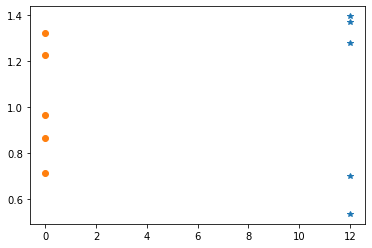

In [3]:
import matplotlib.pyplot as plt
plt.plot(flow[0, :], v[:, 0], '*')
plt.plot(flow[1, :], v[:, 1], 'o')

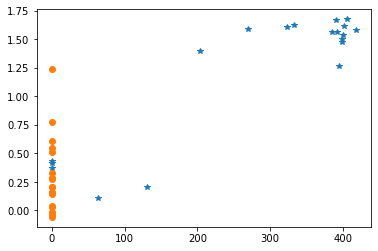

In [11]:
plt.plot(flow[0, :], v[:, 0], '*')
plt.plot(flow[1, :], v[:, 1], 'o')

In [4]:
x_train = np.concatenate([x_train, x_val], axis=0)
with torch.no_grad():
    x_up = torch.FloatTensor(x_train[..., src].transpose(2, 0, 1)) # [num of src, batch_size, num_timesteps_input], num of src = num of dst = num of edges
    x_down = torch.FloatTensor(x_train[..., dst].transpose(2, 0, 1)) # [num of dst, batch_size, num_timesteps_input]
    v = model.velocity_model(x_up, x_down).numpy()
    flow = torch.sum(x_up, dim=2).numpy()
    down_flow = torch.sum(x_down, dim=2).numpy()

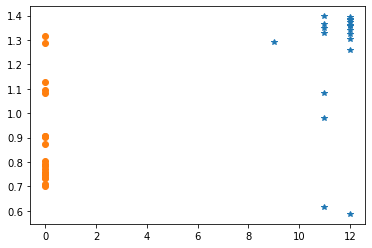

In [5]:
plt.plot(flow[0, :], v[:, 0], '*')
plt.plot(flow[1, :], v[:, 1], 'o')

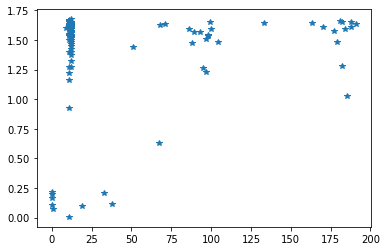

In [18]:
plt.plot(flow[0, :], v[:, 0], '*')
# plt.plot(flow[1, :], v[:, 1], 'o')

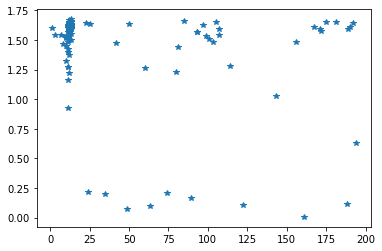

In [17]:
plt.plot(down_flow[0, :], v[:, 0], '*')
# plt.plot(down_flow[1, :], v[:, 1], 'o')

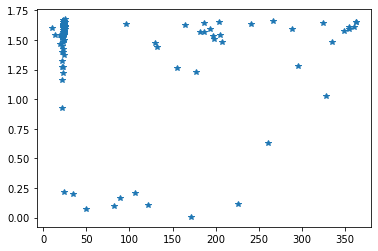

In [20]:
plt.plot(down_flow[0, :] + flow[0, :], v[:, 0], '*')

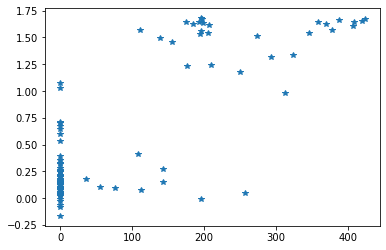

In [21]:
plt.plot(down_flow[1, :] + flow[1, :], v[:, 1], '*')